## Simple tree with 2-dim kernel of Laplacian

In [1]:
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import matplotlib.pyplot as plt
import numpy as np

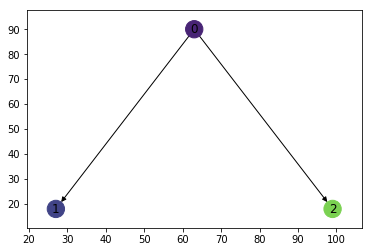

In [2]:
G = nx.balanced_tree(create_using=nx.DiGraph(), h=1, r=2)
N = nx.number_of_nodes(G)
layout = graphviz_layout(G, prog='dot')
#init = np.random.normal(loc=0, scale=4, size=N)
init = np.array([0.1, 0.2, 0.8])
nx.draw_networkx(G, pos=layout, node_color=init, vmin=0, vmax=1)

Reverse the direction of an edge not connected to the root

In [3]:
G.remove_edge(0,1)
G.add_edge(1,0)
G.remove_edge(0,2)
G.add_edge(2,0)

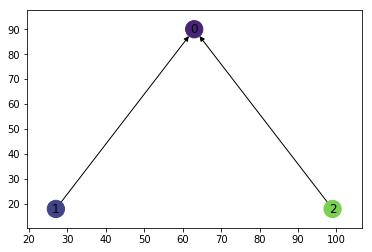

In [4]:
nx.draw_networkx(G, pos=layout, node_color=init, vmin=0, vmax=1)

Simulate simple consensus

In [5]:
A = nx.adjacency_matrix(G).transpose()
D = np.diag(np.asarray(np.sum(A, axis=1)).reshape(-1))
L = D - A
np.linalg.matrix_rank(L)

1

In [6]:
from scipy.integrate import solve_ivp

In [7]:
f1 = lambda t,x: np.asarray(L.dot(x))[0]
res1 = solve_ivp(fun=f1, t_span=[0,10], y0=init)

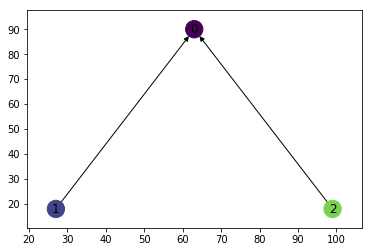

In [8]:
nx.draw_networkx(G, pos=layout, node_color=res1.y[:,-1], vmin=0, vmax=1)

### Symmetrization

In [9]:
from scipy.linalg import null_space
from scipy.linalg import solve_lyapunov

In [10]:
def orth_matrix(A):
    u, s, vh = np.linalg.svd(A, full_matrices=True)
    M, N = u.shape[0], vh.shape[1]
    rcond = np.finfo(s.dtype).eps * max(M, N)
    tol = np.amax(s) * rcond
    num = np.sum(s > tol, dtype=int)
    Q = vh[0:num,:].T.conj()
    return Q

In [11]:
Q = orth_matrix(L).T
rL = np.matmul(Q, np.matmul(L, np.transpose(Q)))
sigma = solve_lyapunov(rL, np.identity(np.linalg.matrix_rank(L)))
x = 2*np.matmul(np.transpose(Q), np.matmul(sigma, Q))
eqL = np.linalg.pinv(x)

In [12]:
x

matrix([[ 0.33333333, -0.16666667, -0.16666667],
        [-0.16666667,  0.08333333,  0.08333333],
        [-0.16666667,  0.08333333,  0.08333333]])

In [13]:
eqL

matrix([[ 1.33333333, -0.66666667, -0.66666667],
        [-0.66666667,  0.33333333,  0.33333333],
        [-0.66666667,  0.33333333,  0.33333333]])

In [14]:
np.linalg.svd(eqL)

(matrix([[-0.81649658,  0.40824829,  0.40824829],
         [ 0.40824829,  0.90824829, -0.09175171],
         [ 0.40824829, -0.09175171,  0.90824829]]),
 array([2.00000000e+00, 5.06745162e-17, 0.00000000e+00]),
 matrix([[-8.16496581e-01,  4.08248290e-01,  4.08248290e-01],
         [-3.65148372e-01,  1.82574186e-01, -9.12870929e-01],
         [-4.47213595e-01, -8.94427191e-01,  1.11022302e-16]]))

In [15]:
f2 = lambda t,x: np.asarray(eqL.dot(x))[0]
res2 = solve_ivp(fun=f2, t_span=[0,10], y0=init)

In [16]:
res2.y[:,-1]

array([-1.29215635e+08,  6.46078179e+07,  6.46078185e+07])

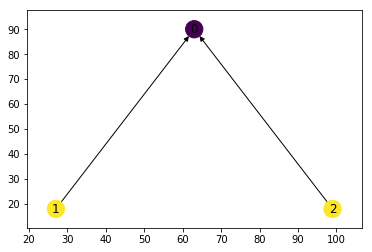

In [17]:
nx.draw_networkx(G, pos=layout, node_color=res2.y[:,-1], vmin=0, vmax=1)

Create undirected graph from the equivalent Laplacian

In [18]:
eqG = nx.Graph()

for i in np.arange(0,np.shape(eqL)[0]):
    for j in np.arange(i+1,np.shape(eqL)[1]):
        print(str(i)+','+str(j))
        if(np.abs(eqL[i,j]) > 1e-6):
            eqG.add_edge(i,j,weight=eqL[i,j])

0,1
0,2
1,2


In [19]:
nx.is_connected(eqG)

True

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


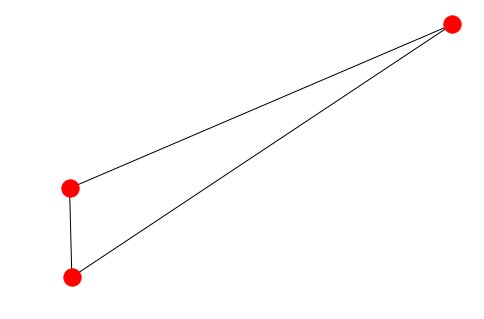

In [20]:
nx.draw(eqG)

In [21]:
eqL

matrix([[ 1.33333333, -0.66666667, -0.66666667],
        [-0.66666667,  0.33333333,  0.33333333],
        [-0.66666667,  0.33333333,  0.33333333]])

In [22]:
np.diag(eqL)

array([1.33333333, 0.33333333, 0.33333333])

In [23]:
res2.y[:,-1]

array([-1.29215635e+08,  6.46078179e+07,  6.46078185e+07])

Final result

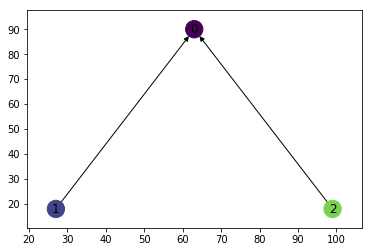

In [24]:
nx.draw_networkx(G, node_color = res1.y[:,-1], pos=layout, vmin=0, vmax=1)

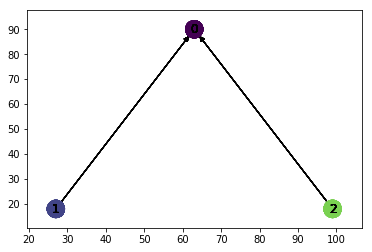

In [25]:
for i in np.arange(0,np.size(res1.t)):
    nx.draw_networkx(G, pos=layout, node_color=res1.y[:,i], vmin=0, vmax=1)
    plt.savefig("./images/trees/tree"+str(i).zfill(2)+".png")

In [26]:
!convert -delay 20 images/trees/* images/trees.gif

In [27]:
from IPython.display import Image
Image(url='./images/trees.gif')

In [28]:
np.linalg.matrix_rank(eqL)

1

In [29]:
eqL

matrix([[ 1.33333333, -0.66666667, -0.66666667],
        [-0.66666667,  0.33333333,  0.33333333],
        [-0.66666667,  0.33333333,  0.33333333]])

In [30]:
g_neg = eqG.subgraph([1,2])

In [31]:
print(nx.adjacency_matrix(g_neg))

  (0, 1)	0.33333333333333326
  (1, 0)	0.33333333333333326


In [32]:
nx.laplacian_matrix(g_neg).todense()

matrix([[ 0.33333333, -0.33333333],
        [-0.33333333,  0.33333333]])

In [33]:
np.linalg.eig(nx.laplacian_matrix(g_neg).todense())

(array([6.66666667e-01, 5.55111512e-17]), matrix([[ 0.70710678,  0.70710678],
         [-0.70710678,  0.70710678]]))